<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w3d4_fixes/tutorials/W3D4_ContinualLearning/W3D4_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Introduction to Continual Learning
**Week 3, Day 4: Continual Learning**

**By Neuromatch Academy**

__Content creators:__ Keiland Cooper, Diganta Misra, Gido van de Ven, Andrea Cossu, Vincenzo Lomonaco

__Content reviewers:__ Arush Tagade, Jeremy Forest, Siwei Bai

__Content editors:__ Anoop Kulkarni, Spiros Chavlis

__Production editors:__ Deepak Raya, Spiros Chavlis


---
# Tutorial Objectives

In this tutorial we'll dive head-first into the exciting field of continual learning (CL). CL has gained increasing attention in recent years, and for good reason. CL is positioned as a problem across sub-disciplines, from academia to industry, and may promise to be a major pathway towards strong artificial intelligence (AI). As datasets get bigger and AI gets smarter, we're expecting more and more cognitive capabilities from our machines. 

We have a few specific objectives for this tutorial:
*   Introduce major CL concepts
*   Introduce the most common strategies to aid CL
*   Utilize benchmarks and evaluation metrics 
*   Explore present day applications of CL 

In [1]:
# @title Video 0: Overview of the session and introduction to continual learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1LM4y1T7Wn", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ARVxFIfw4JU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In [2]:
# @title Tutorial slides

# @markdown These are the slides for the videos in this tutorial
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/ejywm/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

First, let's load in some useful packages and functions. We'll primarily be using PyTorch as our neural network framework of choice. Be sure to run all the cells below so the code runs properly. 

In [3]:
# @title Install dependencies
!pip install seaborn --quiet

In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [5]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [6]:
# @title Plotting and Utils Helper functions

# If any helper functions you want to hide for clarity, add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


def plot_mnist(data, nPlots=10):
  """ Plot MNIST-like data """
  f, axarr = plt.subplots(1,nPlots)
  for ii in range(nPlots):
    axarr[ii].imshow(data[ii,0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);
  plt.show()


def permute_mnist(mnist, seed, verbose=False):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    if verbose: print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    if verbose: print("done.")
    return perm_mnist


def multi_task_barplot(accs, tasks, t=None):
  ''' Plot n task accuracy
      used for S1 intro to CF code '''
  nTasks = len(accs)
  plt.bar(range(nTasks), accs, color='k')
  plt.ylabel('Testing Accuracy (%)', size=18)
  plt.xticks(range(nTasks),
            [f'{TN}\nTask {ii+1}' for ii,TN in enumerate(tasks.keys())],
            size=18)
  plt.title(t)


def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    # np.vectorize(lambda ax:ax.axis('off'))(axs[sample]);
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [10]:
# @title Data-loader Helper functions (MNIST and core50)

# TODO:
# We need a more permenate solution for this...
# https://github.com/pytorch/vision/issues/1938

# we should also probably supress most of this output
# unless we change the source of the data

print('Downloading and unpacking MNIST data. Please wait a moment...\n')

# The MNIST repo on LeCun's website nor AWS seem to be availible
# This is one popular private repo, but beware
# PyTorch is reported to be hosting one soon...
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

mnist_train = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=True)
mnist_test = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=False)

def load_mnist(verbose=False, asnumpy=True):
    '''
    Helper function to maintain compatability with
    previous MNIST dataloaders in CLAI COLAB

    Much of this can likely now be fixed with the toTensor call on inport
    Or by using proper PyTorch functions... lol

    - KWC
    '''

    x_traint, t_traint = mnist_train.data, mnist_train.targets
    x_testt, t_testt = mnist_test.data, mnist_test.targets

    if asnumpy:
      # Fix dimensions and convert back to np array for code compatability
      # We aren't using torch dataloaders for ease of use
      x_traint = torch.unsqueeze(x_traint, 1)
      x_testt = torch.unsqueeze(x_testt, 1)
      x_train, x_test = x_traint.numpy().copy(), x_testt.numpy()
      t_train, t_test = t_traint.numpy().copy(), t_testt.numpy()
    else:
      x_train, t_train = x_traint, t_traint
      x_test, t_test = x_testt, t_testt

    if verbose:
      print("x_train dim and type: ", x_train.shape, x_train.dtype)
      print("t_train dim and type: ", t_train.shape, t_train.dtype)
      print("x_test dim and type: ", x_test.shape, x_test.dtype)
      print("t_test dim and type: ", t_test.shape, t_test.dtype)
      print()


    return x_train, t_train, x_test, t_test

print('\nDownloading core50 in the background...')
# this lines of code will download core50 in background. We suggest to run it at the start of the notebook
!wget http://raw.githubusercontent.com/ContinualAI/colab/master/scripts/download_and_extract_core50_mini.sh
!nohup sh download_and_extract_core50_mini.sh &

print('Core50 will be silently unpacked in the backgroud. Please continue.')


--2021-07-23 16:42:31--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-07-23 16:42:31--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  18.3MB/s    in 1.8s    

2021-07-23 16:42:33 (18.3 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tr

---
# Section 1: The sequential learning problem: catastrophic forgetting

In [11]:
# @title Video 1: Introduction to catastrophic forgetting
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1kg411M7wu", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"WIbgFxzaFP4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Here we'll explore catastrophic forgetting first hand, a key barrier preventing continual learning in neural networks. To do so, we'll build a simple network model and try our best to teach it the trusty MNIST dataset

## Section 1.1: A brief example of catastrophic forgetting 

Let's define a simple CNN that can perform fairly well on MNIST. We'll also load in some training and testing functions we wrote to load the data into the model and train / test it. We don't need to get into the details how they work for now (pretty standard) but feel free to double click the cell if you're curious!

In [12]:
# Here we define a simple multilayer CNN. Nothing too fancy
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    """ run the network forward
    (uses the functional library (F) imported from pytorch)"""
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return x

In [13]:
# @title Model Training and Testing Functions [RUN ME!]

# @markdown `train(model, device, x_train, t_train, optimizer, epoch)`
def train(model, device, x_train, t_train, optimizer, epoch):
  """
  Train fnction
  """
  model.train()

  for start in range(0, len(t_train)-1, 256):
    end = start + 256
    x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
    y = torch.from_numpy(t_train[start:end]).long()
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()

    output = model(x)
    loss = F.cross_entropy(output, y)
    loss.backward()
    optimizer.step()
  print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


# @markdown `test(model, device, x_test, t_test)`
def test(model, device, x_test, t_test):
    """
    Test function.
    """
    model.eval()
    correct, test_loss = 0, 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x = torch.from_numpy(x_test[start:end]).type(torch.cuda.FloatTensor)
        y = torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item()  # sum up batch loss
        pred = output.max(1, keepdim=True)[1]  # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [14]:
class simpNet(nn.Module):
  def __init__(self):
    super(simpNet,self).__init__()
    self.linear1 = nn.Linear(28*28, 320)
    self.out = nn.Linear(320, 10)
    self.relu = nn.ReLU()

  def forward(self, img):
    x = img.view(-1, 28*28)
    x = self.relu(self.linear1(x))
    x = self.out(x)
    return x

Now let's load in our dataset, MNIST. We'll also run a function we defined in the helper function cell above that permutes (scrambles) the images. This allows us to create additional datasets with similar statistics to MNIST on the fly. We'll call the normal MNIST Task 1, and the permuted MNIST Task 2. We'll see why in a second!

x_train dim and type:  (60000, 1, 28, 28) uint8
t_train dim and type:  (60000,) int64
x_test dim and type:  (10000, 1, 28, 28) uint8
t_test dim and type:  (10000,) int64

Task 1: MNIST Training data:


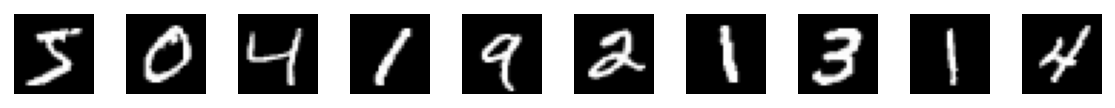


Task 2: Permuted MNIST data:


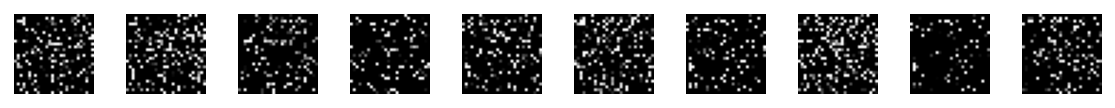

In [15]:
# Load in MNIST and create an additional permuted dataset
x_train, t_train, x_test, t_test = load_mnist(verbose=True)
x_train2, x_test2 = permute_mnist([x_train, x_test], 0, verbose=False)

# Plot the data to see what we're working with
print('Task 1: MNIST Training data:')
plot_mnist(x_train, nPlots=10)
print('\nTask 2: Permuted MNIST data:')
plot_mnist(x_train2, nPlots=10)

Great! We have our data. This commonly  used task is typically called the "permuted MNIST [task](https://arxiv.org/pdf/1312.6211.pdf)", given the shuffling of the data. The permutations are the same across all images in the same task (all the permuted image in that task follow are permuted in the same way). This is useful as it allows you to create almost as many tasks as you would like out of the same dataset. While it may [not be the best benchmark for CL](https://arxiv.org/pdf/1805.09733.pdf), it is commonly used, and will serve our purposes well enough for illustration. 

Now, let's initialize and train our model on the standard MNIST dataset (Task 1) and make sure everything is working properly. 

In [16]:
# Define a new model and set params
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model on MNIST
nEpochs = 3
print(f'Training model on {nEpochs} epochs...')
for epoch in range(1, nEpochs+1):
  train(model, DEVICE, x_train, t_train, optimizer, epoch)
  test(model, DEVICE, x_test, t_test)

Training model on 3 epochs...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 	Loss: 1.214747
Test set: Average loss: 0.0004, Accuracy: 8039/10000 (80%)

Train Epoch: 2 	Loss: 0.767283
Test set: Average loss: 0.0002, Accuracy: 8951/10000 (90%)

Train Epoch: 3 	Loss: 0.822623
Test set: Average loss: 0.0002, Accuracy: 9138/10000 (91%)



Okay great! It seems we get decent accuracy on standard MNIST which means the model is learning our dataset. Now, a reasonable assumption is that, like humans, once the network learns something, it can aggregate its knowledge and learn something else. 

First, let's get a baseline for how the model performs on the dataset it was just trained on (Task 1) as well as to see how well it performs on a new dataset (Task 2). 

Testing on task 1
Test set: Average loss: 0.0002, Accuracy: 9138/10000 (91%)

Testing on task 2
Test set: Average loss: 0.0018, Accuracy: 1275/10000 (13%)



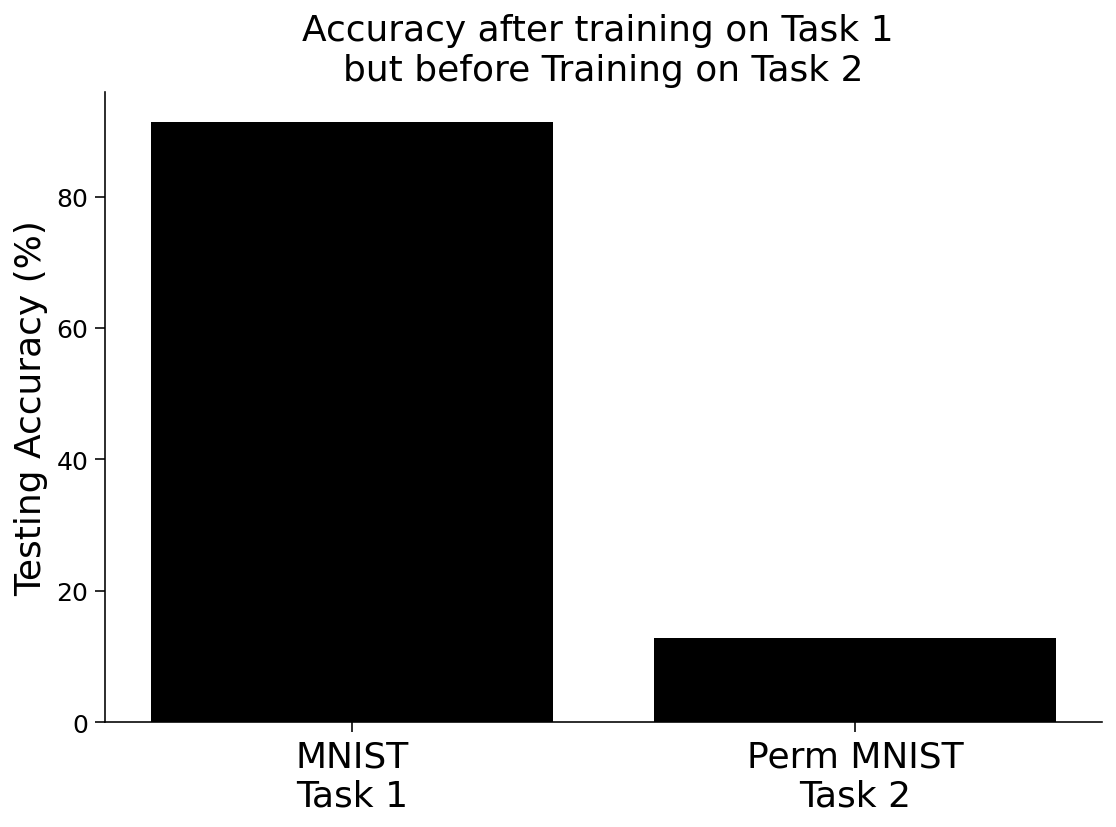

In [17]:
# test the model's accuracy on both the regular and permuted dataset

# Let's define a dictionary that holds each of the task
# datasets and labels
tasks = {'MNIST':(x_test, t_test),
         'Perm MNIST':(x_test2, t_test)}
t1_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti+1}")
  t1_accs.append(test(model, DEVICE, tasks[task][0], tasks[task][1]))

# And then let's plot the testing accuracy on both datasets
multi_task_barplot(t1_accs, tasks, t='Accuracy after training on Task 1 \nbut before Training on Task 2')

As we saw before, the model does great on the Task 1 dataset it was trained on, but not so well on the new one. No worries! We haven't taught it the permuted MNIST dataset yet! So let's train the *same* task 1-trained-model on the new data, and see if we can get comparable performance between the two types of MNIST

Train Epoch: 1 	Loss: 1.702754
Test set: Average loss: 0.0008, Accuracy: 6181/10000 (62%)

Train Epoch: 2 	Loss: 1.513332
Test set: Average loss: 0.0006, Accuracy: 7337/10000 (73%)

Testing on task 1
Test set: Average loss: 0.0016, Accuracy: 1384/10000 (14%)

Testing on task 2
Test set: Average loss: 0.0006, Accuracy: 7337/10000 (73%)



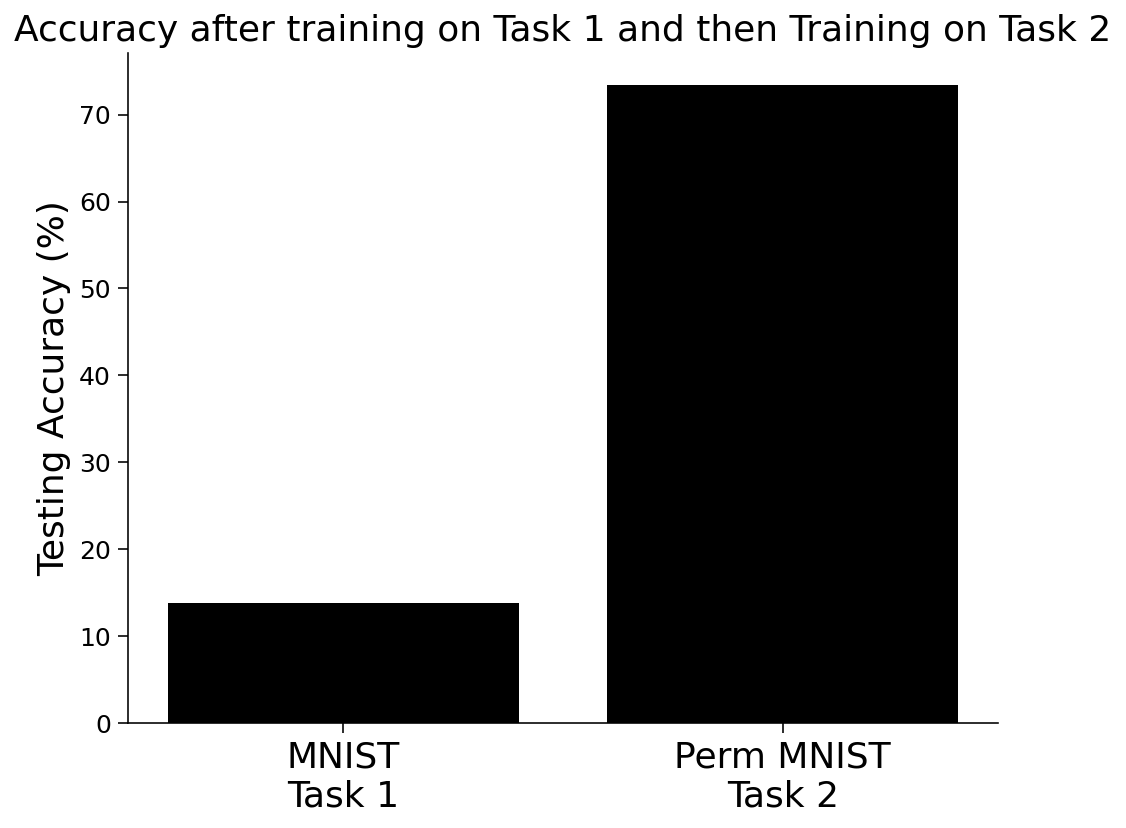

In [18]:
# Train the previously trained model on Task 2, the permuted MNIST dataset
for epoch in range(1, 3):
  train(model, DEVICE, x_train2, t_train, optimizer, epoch)
  test(model, DEVICE, x_test2, t_test)

# Same data as before, stored in a dict
tasks = {'MNIST':(x_test, t_test),
         'Perm MNIST':(x_test2, t_test)}
# Test the model on both datasets, same as before
t12_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti+1}")
  t12_accs.append(test(model, DEVICE, tasks[task][0], tasks[task][1]))

# And then let's plot each of the testing accuracies after the new training
multi_task_barplot(t12_accs, tasks, t='Accuracy after training on Task 1 and then Training on Task 2')

Hey! Training did the trick, task 2 (permuted MNIST) has great accuracy now that we trained the model on it. But something is wrong. We just saw that Task 1 (standard MNIST) had high accuracy before we trained on the new task. What gives? Try to incorporate what you learned in the lecture to help explain the problem we're seeing. You might also take a few seconds and think of what possible soultions you might like to try. In the next section, we'll look into exactly that!

---
# Section 2: Continual Learning strategies

In [19]:
# @title Video 2: CL strategies
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1RP4y14792", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"q3aZGXIYYfw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Split MNIST

For this section we will again use the MNIST dataset, but we will now create 5 tasks by splitting the dataset up in such a way that each task contains 2 classes. This problem is called Split MNIST, and it is popular toy problem in the continual learning literature

Random seed 2021 has been set.


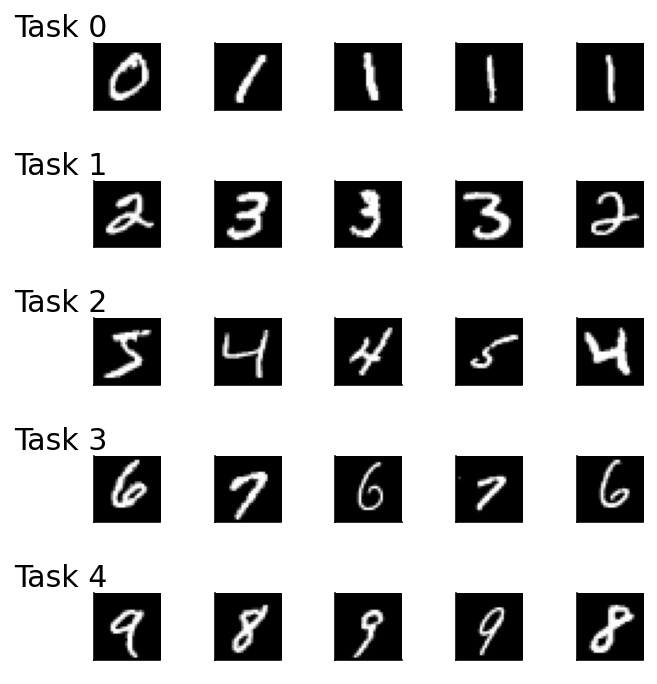

In [20]:
set_seed(seed=SEED)
# Specify which classes should be part of which task
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

# Divide the data over the different tasks
task_data_with_overlap = []
for task_id, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  # Convert the original class labels (i.e., the digits 0 to 9) to
  # "within-task labels" so that within each task one of the digits is labelled
  # as '0' and the other as '1'.
  task_data_with_overlap.append((x_train_task, t_train_task - (task_id * 2),
                                 x_test_task, t_test_task - (task_id * 2)))

# Display tasks
n_tasks, samples = 5, 5
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 5))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data_with_overlap[task][0], samples)
plt.tight_layout()

## Naive strategy ("fine-tuning")
First, let's see what happens if we simply sequentially train a deep neural network on these tasks in the standard way.

Let's start by defining our network. As is common in the continual learning literature, we will use a "multi-headed layout". This means that we have a separate output layer for each task to be learned, but the hidden layers of the network are shared between all tasks.

In [21]:
## Base network that is shared between all tasks
class FBaseNet(nn.Module):
  def __init__(self, hsize=512):
    super(FBaseNet, self).__init__()
    self.l1 = nn.Linear(784, hsize)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    return x

## Output layer, which will be separate for each task
class FHeadNet(nn.Module):
  def __init__(self, base_net, input_size=512):
    super(FHeadNet, self).__init__()

    self.base_net = base_net
    self.output_layer = nn.Linear(input_size, 2)

  def forward(self, x):
    x = self.base_net.forward(x)
    x = self.output_layer(x)
    return x

In [22]:
# Define the base network (a new head is defined when we encounter a new task)
base = FBaseNet().to(DEVICE)
heads = []

# Define a list to store test accuracies for each task
accs_naive = []

# Set the number of epochs to train each task for
epochs = 3

# Loop through all tasks
for task_id in range(tasks_num):
  # Collect the training data for the new task
  x_train, t_train, _, _ = task_data_with_overlap[task_id]

  # Define a new head for this task
  model = FHeadNet(base).to(DEVICE)
  heads.append(model)

  # Set the optimizer
  optimizer = optim.SGD(heads[task_id].parameters(), lr=0.01)

  # Train the model (with the new head) on the current task
  train(heads[task_id], DEVICE, x_train, t_train, optimizer, epochs)

  # Test the model on all tasks seen so far
  accs_subset = []
  for i in range(0, task_id + 1):
    _, _, x_test, t_test = task_data_with_overlap[i]
    test_acc = test(heads[i], DEVICE, x_test, t_test)
    accs_subset.append(test_acc)
  # For unseen tasks, we don't test
  if task_id < (tasks_num - 1):
    accs_subset.extend([np.nan] * (4 - task_id))
  # Collect all test accuracies
  accs_naive.append(accs_subset)

Train Epoch: 3 	Loss: 0.000000
Test set: Average loss: 0.0000, Accuracy: 2113/2115 (100%)

Train Epoch: 3 	Loss: 0.454459
Test set: Average loss: 0.0032, Accuracy: 1917/2115 (91%)

Test set: Average loss: 0.0001, Accuracy: 1853/2042 (91%)

Train Epoch: 3 	Loss: 0.041911
Test set: Average loss: 0.0079, Accuracy: 1128/2115 (53%)

Test set: Average loss: 0.0008, Accuracy: 1464/2042 (72%)

Test set: Average loss: 0.0000, Accuracy: 1858/1874 (99%)

Train Epoch: 3 	Loss: 0.005111
Test set: Average loss: 0.0087, Accuracy: 1064/2115 (50%)

Test set: Average loss: 0.0022, Accuracy: 1060/2042 (52%)

Test set: Average loss: 0.0003, Accuracy: 1602/1874 (85%)

Test set: Average loss: 0.0000, Accuracy: 1965/1986 (99%)

Train Epoch: 3 	Loss: 0.383279
Test set: Average loss: 0.0034, Accuracy: 1596/2115 (75%)

Test set: Average loss: 0.0006, Accuracy: 1352/2042 (66%)

Test set: Average loss: 0.0010, Accuracy: 926/1874 (49%)

Test set: Average loss: 0.0014, Accuracy: 891/1986 (45%)

Test set: Average lo

As you can see, whenever this network is trained on a new task, its performance on previously learned tasks drops substantially.

Now, let's see whether we can use a continual learning strategy to prevent such forgetting.

## Elastic Weight Consolidation (EWC)

EWC is a popular CL strategy which involves computing the importance of weights of the network relative to the task using the Fisher score and then penalizing the network for changes to the most important weights of the previous task. 

It was introduced in the paper "[Overcoming catastrophic forgetting in neural networks
](https://arxiv.org/abs/1612.00796)". 

For EWC, we need to define a new function to compute the fisher information matrix for each weight at the end of every task:

In [23]:
def on_task_update(task_id, x_mem, t_mem, model, shared_model, fisher_dict,
                   optpar_dict, device):

  model.train()
  optimizer.zero_grad()

  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
    end = start + 256
    x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
    y = torch.from_numpy(t_train[start:end]).long()
    x, y = x.to(device), y.to(device)
    output = model(x)
    loss = F.cross_entropy(output, y)
    loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in shared_model.named_parameters():
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We also need to modify our train function to add the new regularization loss:

In [24]:
def train_ewc(model, shared_model, device, task_id, x_train, t_train, optimizer,
              epoch, ewc_lambda, fisher_dict, optpar_dict):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)

      ### magic here! :-)
      for task in range(task_id):
        for name, param in shared_model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Now let's train with EWC:

In [25]:
# Define the base network (a new head is defined when we encounter a new task)
base = FBaseNet().to(DEVICE)
heads = []

# Define a list to store test accuracies for each task
accs_ewc = []

# Set number of epochs
epochs = 2

# Set EWC hyperparameter
ewc_lambda = 0.4

# Define dictionaries to store values needed by EWC
fisher_dict = {}
optpar_dict = {}

# Loop through all tasks
for task_id in range(tasks_num):
    # Collect the training data for the new task
    x_train, t_train, _, _ = task_data_with_overlap[task_id]

    # Define a new head for this task
    model = FHeadNet(base).to(DEVICE)
    heads.append(model)

    # Set the optimizer
    optimizer = optim.SGD(heads[task_id].parameters(), lr=0.01)

    # Train the model (with the new head) on the current task
    for epoch in range(1, epochs+1):
        train_ewc(heads[task_id], heads[task_id].base_net, DEVICE, task_id,
                  x_train, t_train, optimizer, epoch, ewc_lambda, fisher_dict,
                  optpar_dict)
    on_task_update(task_id, x_train, t_train, heads[task_id],
                   heads[task_id].base_net, fisher_dict, optpar_dict, DEVICE)

    # Test the model on all tasks seen so far
    accs_subset = []
    for i in range(0, task_id + 1):
        _, _, x_test, t_test = task_data_with_overlap[i]
        test_acc = test(heads[i], DEVICE, x_test, t_test)
        accs_subset.append(test_acc)
    # For unseen tasks, we don't test
    if task_id < (tasks_num - 1):
        accs_subset.extend([np.nan] * (4 - task_id))
    # Collect all test accuracies
    accs_ewc.append(accs_subset)

Train Epoch: 1 	Loss: 0.005015
Train Epoch: 2 	Loss: 0.001974
Test set: Average loss: 0.0004, Accuracy: 2108/2115 (100%)

Train Epoch: 1 	Loss: 8.239402
Train Epoch: 2 	Loss: 0.151818
Test set: Average loss: 0.0009, Accuracy: 1012/2115 (48%)

Test set: Average loss: 0.0005, Accuracy: 1664/2042 (81%)

Train Epoch: 1 	Loss: nan
Train Epoch: 2 	Loss: nan
Test set: Average loss: nan, Accuracy: 980/2115 (46%)

Test set: Average loss: nan, Accuracy: 1032/2042 (51%)

Test set: Average loss: nan, Accuracy: 982/1874 (52%)

Train Epoch: 1 	Loss: nan
Train Epoch: 2 	Loss: nan
Test set: Average loss: nan, Accuracy: 980/2115 (46%)

Test set: Average loss: nan, Accuracy: 1032/2042 (51%)

Test set: Average loss: nan, Accuracy: 982/1874 (52%)

Test set: Average loss: nan, Accuracy: 958/1986 (48%)

Train Epoch: 1 	Loss: nan
Train Epoch: 2 	Loss: nan
Test set: Average loss: nan, Accuracy: 980/2115 (46%)

Test set: Average loss: nan, Accuracy: 1032/2042 (51%)

Test set: Average loss: nan, Accuracy: 982/1

Text(0.5, 12.200000000000024, 'Task Number')

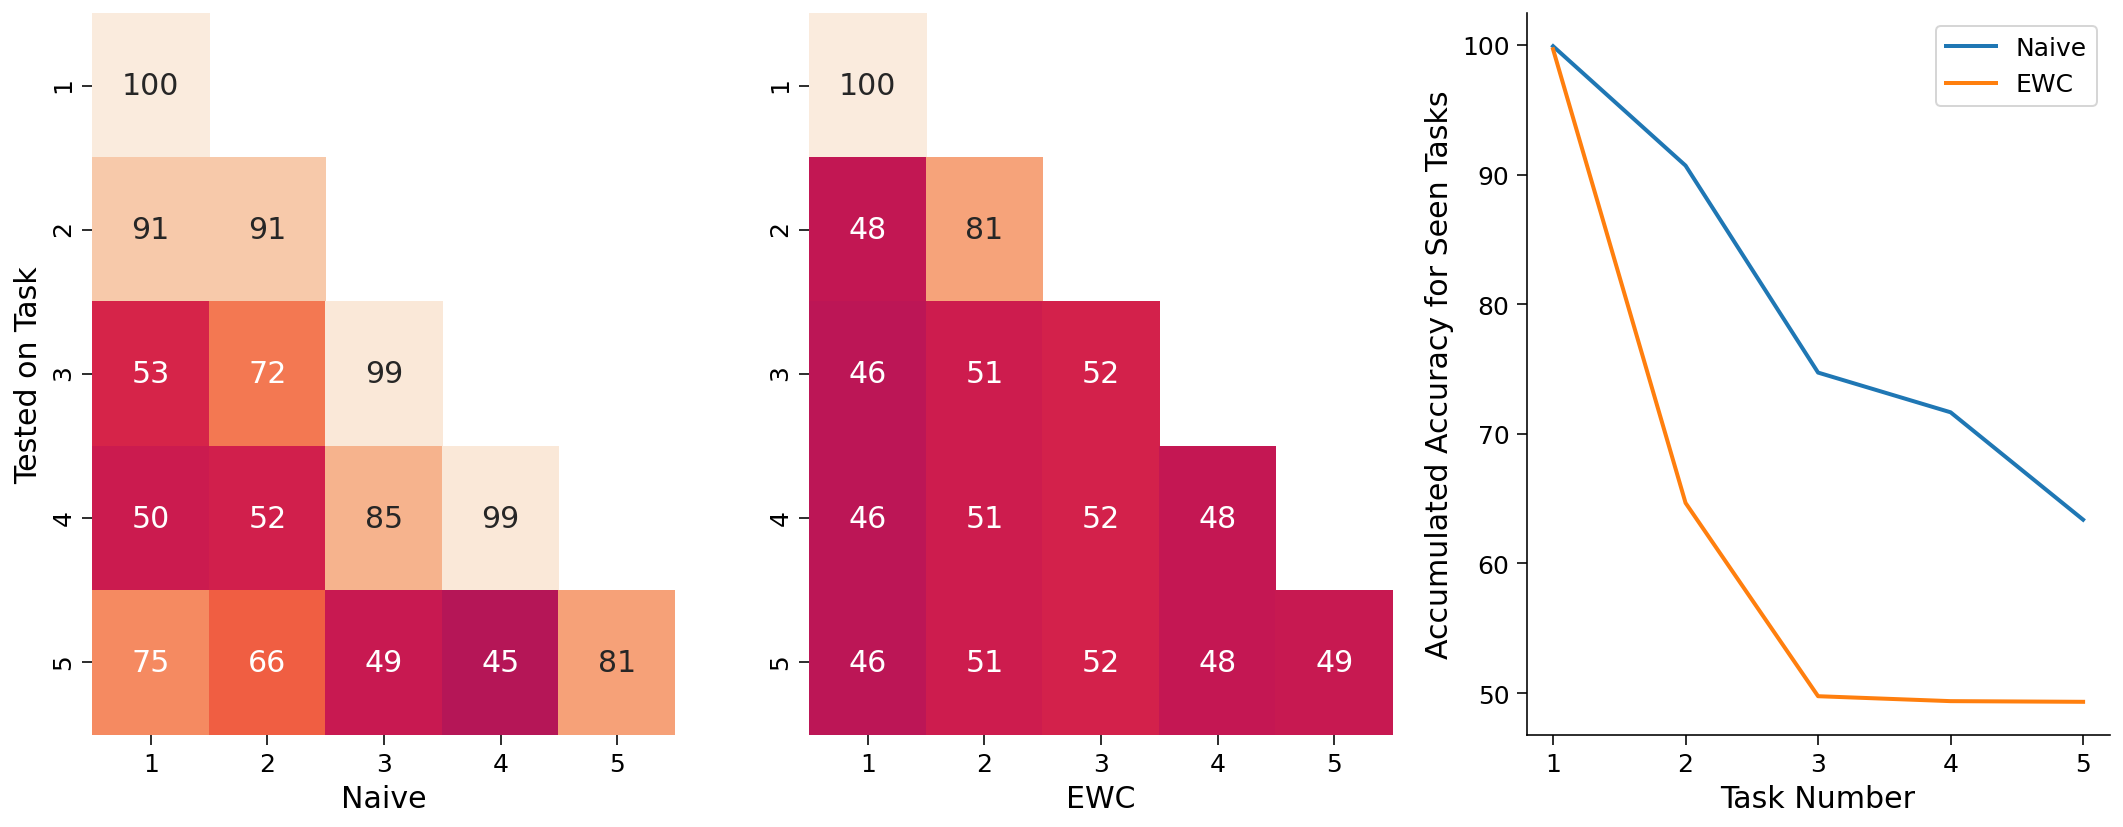

In [26]:
# @title Plot Naive vs EWC results

# @markdown `seaborn` library should be installed
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_ewc, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('EWC')

axes[2].plot(range(1, 6), np.nanmean(accs_naive, axis=1), linewidth=2.0)
axes[2].plot(range(1, 6), np.nanmean(accs_ewc, axis=1), linewidth=2.0)

axes[2].legend(['Naive', 'EWC'])
axes[2].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[2].set_xlabel('Task Number')

---
# Section 3: Continual learning benchmarks

In this section, we will introduce different ways in which a continual learning problem could be set up.

In [27]:
# @title Video 3: Benchmarks and different types of continual learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1R64y1s7EU", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"gQYyFWI3X2s", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

As introduced in the above video, continual learning research certainly does not only use the MNIST dataset.
But not to make things more complicated than necessary (and to make sure the examples run in an acceptable amount of time), we continue with the Split MNIST example for now.
At the end of this notebook we will take a sneak peak at the CORe50 dataset.

Another point made in the video is that continual learning is not a unitary problem, but that there are different types (or 'scenarios') of continual learning:
-	**Task-incremental learning**: an algorithm must incrementally learn a set of clearly distinct tasks (the tasks are clearly distinct because the algorithm is always told which task it must perform)
-	**Domain-incremental learning**: an algorithm must learn the same kind of task but in different contexts or domains
-	**Class-incremental learning**: an algorithm must incrementally learn to distinguish between an increasing number of classes.

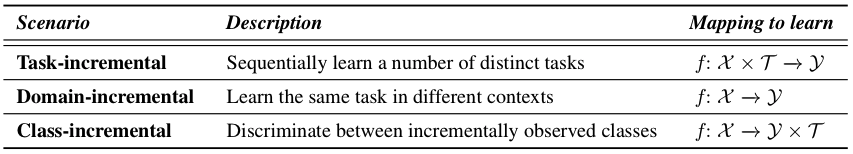

These continual learning scenarios can be distinguished from each other based on whether task identity information (or the task label) is provided to the algorithm, and – if it is not – whether task identity must be inferred (see schematic in the lecture slides).

In [this paper](https://arxiv.org/abs/1904.07734) you can find more details about these different types of continual learning.

## Task-incremental Split MNIST *versus* class-incremental Split MNIST

Now, let's get back to our Split MNIST example. To start with, let's identify according to which scenario Split MNIST was performed in the previous section.

Recall that the Split MNIST problem consists of five tasks, whereby each task contains two digits. In the previous section, the model was set-up in such a way that it had a separate output layer for each of these tasks (this is typically called a '*multi-headed output layer*'). At test time, the model then used the output layer of the task to which the example to be classified belonged. This means that it was assumed that the model always knows which task it must perform, so this was an example of **task-incremental learning**.

In the continual learning literature. this variant of Split MNIST is also referred to as ***multi-headed Split MNIST***.
However, although a multi-headed output layer is probably the most common way to use task identity information, it is not the only way (for example, see [this paper](https://doi.org/10.1073/pnas.1803839115)).

Now, let's reorganize the Split MNIST problem to set it up as a **class-incremental learning** problem. That is, task information is no longer provided to the model; and the model must be able to decide itself to which task a test sample belongs.
This means that, after all tasks have been learned, the model must now choose between all ten digits.
This variant of Split MNIST is also referred to as ***single-headed Split MNIST***.

In [28]:
# Load the MNIST dataset
x_train, t_train, x_test, t_test = load_mnist(verbose=True)

# Define which classes are part of each task
classes_per_task = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]

# Divde the MNIST dataset in tasks
task_data = []
for _, classes_in_this_task in enumerate(classes_per_task):

  # Which data-points belong to the classes in the current task?
  train_mask = np.isin(t_train, classes_in_this_task)
  test_mask = np.isin(t_test, classes_in_this_task)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]

  # Add the data for the current task
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))

# In contrast to the task-incremental version of Split MNIST explored in the
# last section, now task identity information will not be provided to the model

x_train dim and type:  (60000, 1, 28, 28) uint8
t_train dim and type:  (60000,) int64
x_test dim and type:  (10000, 1, 28, 28) uint8
t_test dim and type:  (10000,) int64



## Example: EWC on the class-incremental version of Split MNIST

Let's now try the EWC method on this class-incremental version of Split MNIST.

In [29]:
# Define the model and the optimzer
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Set 'lambda', the hyperparameter of EWC
ewc_lambda = 0.4

# Define dictionaries to store values needed by EWC
fisher_dict = {}
optpar_dict = {}

# Prepare list to store average accuracies after each task
ewc_accs = []

# Loop through all tasks
for id, task in enumerate(task_data):

  # Collect training data
  x_train, t_train, _, _ = task

  # Training with EWC
  print("Training on task: ", id)
  for epoch in range(1, 2):
    train_ewc(model, model, DEVICE, id, x_train, t_train, optimizer, epoch,
              ewc_lambda, fisher_dict, optpar_dict)
  on_task_update(id, x_train, t_train, model, model, fisher_dict,
                 optpar_dict, DEVICE)

  # Evaluate performance after training on this task
  avg_acc = 0
  for id_test, task in enumerate(task_data):
    print("Testing on task: ", id_test)
    _, _, x_test, t_test = task
    acc = test(model, DEVICE, x_test, t_test)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / len(task_data))
  ewc_accs.append(avg_acc / len(task_data))

Training on task:  0
Train Epoch: 1 	Loss: 0.433860
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2109/2115 (100%)

Testing on task:  1
Test set: Average loss: 0.0060, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: 0.0068, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0078, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0079, Accuracy: 0/1983 (0%)

Avg acc:  19.94326241134752
Training on task:  1
Train Epoch: 1 	Loss: 1.505296
Testing on task:  0
Test set: Average loss: 0.0016, Accuracy: 159/2115 (8%)

Testing on task:  1
Test set: Average loss: 0.0004, Accuracy: 1770/2042 (87%)

Testing on task:  2
Test set: Average loss: 0.0023, Accuracy: 1/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0031, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0040, Accuracy: 0/1983 (0%)

Avg acc:  18.85016360969398
Training on task:  2
Train Epoch: 1 	Loss: 1.580746
Testing on task:  0
Test se

That didn't work well...

The model only correctly predicts the classes from the last task it has seen, all earlier seen classes seem to be forgotten.

You might wonder whether the reason that EWC performed so badly in the above example is because we chose an unsuitable value for the hyperparameter lambda.
Although we don't have time to demonstrate this, there are no values of lambda that would lead to good performance.

In general, parameter regularization based methods, such as EWC, have been found not to work well on class-incremental learning problems.

## Replay

As discussed in the lecture of the previous section, another popular continual learning strategy is replay. Let's see whether replay works better on the class-incremental learning version of Split MNIST than EWC did.

One implementation of replay is to simply store all data from previously seen tasks, and to then, whenever a new task must be learned, mix in that stored data with the training data of the new task.

To achieve this form of replay, let's define the following function for shuffling multiple datasets (e.g., the data from previous tasks with the data from the current task) together:

In [30]:
def shuffle_datasets(dataset, seed, in_place=False):
  """ Shuffle a list of two (or more) datasets. """

  np.random.seed(seed)
  rng_state = np.random.get_state()
  new_dataset = []
  for x in dataset:
    if in_place:
      np.random.shuffle(x)
    else:
      new_dataset.append(np.random.permutation(x))
    np.random.set_state(rng_state)

  if not in_place:
    return new_dataset

Note that this form of replay is somewhat extreme, as it stores all the training data from previous tasks. In practice, replay is often implemented in ways that store less data, for example either by using relatively small memory buffers (see [this paper](https://arxiv.org/abs/1902.10486)) or by learning a generative model to then generate the data to be replayed (see [this paper](https://arxiv.org/abs/1705.08690) or [this paper](https://www.nature.com/articles/s41467-020-17866-2)).

## Example: Test replay on the class-incremental version of Split MNIST

Let's try whether this replay strategy works better than EWC.

In [31]:
# Define the model and the optimizer
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Prepare list to store average accuracies after each task
rehe_accs = []

# Loop through all tasks
for id, task in enumerate(task_data):

  # Collect training data
  x_train, t_train, _, _ = task

  # Add replay
  for i in range(id):
    past_x_train, past_t_train, _, _ = task_data[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  x_train, t_train = shuffle_datasets([x_train, t_train], seed=SEED)

  # Training
  print("Training on task: ", id)
  for epoch in range(1, 3):
    train(model, DEVICE, x_train, t_train, optimizer, epoch)

  # Evaluate performance after training on this task
  avg_acc = 0
  for id_test, task in enumerate(task_data):
    print("Testing on task: ", id_test)
    _, _, x_test, t_test = task
    acc = test(model, DEVICE, x_test, t_test)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / len(task_data))
  rehe_accs.append(avg_acc/len(task_data))

Training on task:  0
Train Epoch: 1 	Loss: 0.099752
Train Epoch: 2 	Loss: 0.071375
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2115/2115 (100%)

Testing on task:  1
Test set: Average loss: 0.0089, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: 0.0128, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0123, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0092, Accuracy: 0/1983 (0%)

Avg acc:  20.0
Training on task:  1
Train Epoch: 1 	Loss: 0.488018
Train Epoch: 2 	Loss: 0.337126
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2090/2115 (99%)

Testing on task:  1
Test set: Average loss: 0.0000, Accuracy: 1994/2042 (98%)

Testing on task:  2
Test set: Average loss: 0.0045, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0044, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0039, Accuracy: 0/1983 (0%)

Avg acc:  39.29346605446382
Training on task:  2
Train E

And finally, let's compare the performance of EWC and Replay on the class-incremental version of Split MNIST in a plot:

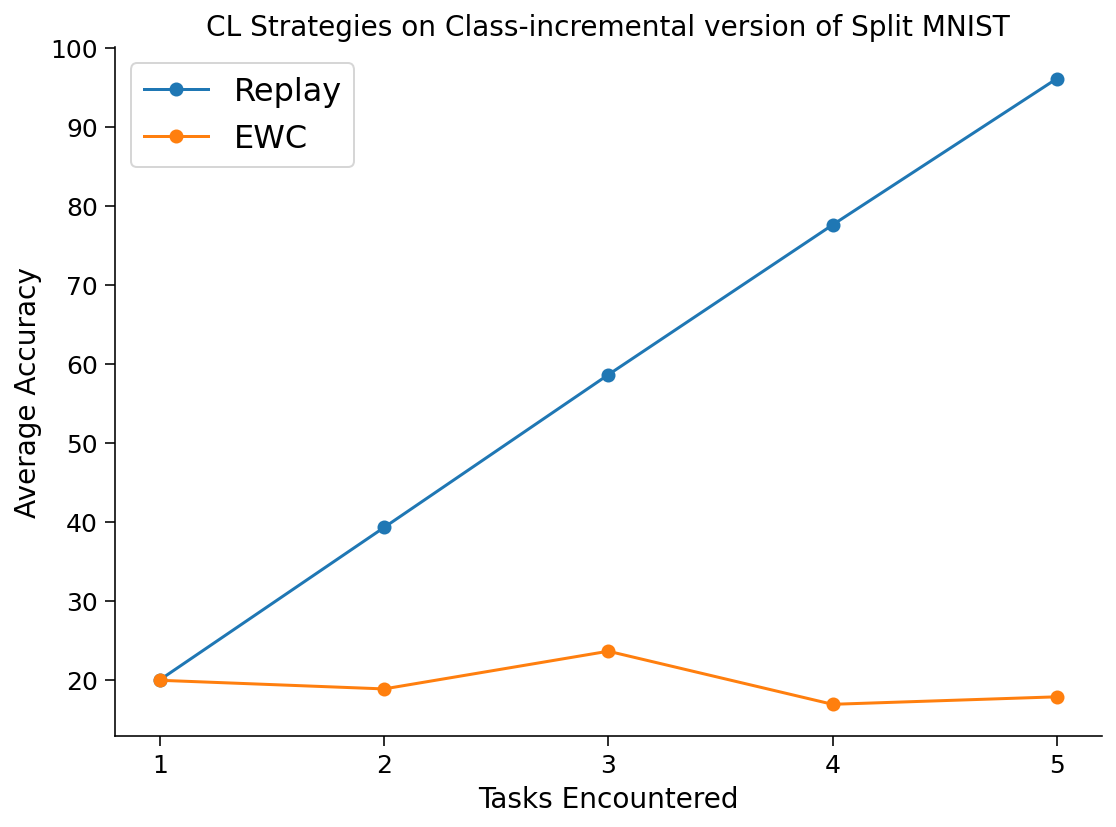

In [32]:
# @title Plot EWC vs. Replay
plt.plot([1, 2, 3, 4, 5], rehe_accs, '-o', label="Replay")
plt.plot([1, 2, 3, 4, 5], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies on Class-incremental version of Split MNIST',
          fontsize=14);
plt.xticks([1, 2, 3, 4, 5])
plt.legend(prop={'size': 16});

## Exercise 3: Identify the continual learning scenario of the permuted MNIST example from Section 1

What type of 'scenario' was the permuted MNIST problem that was introduced in Section 1? Was it task-incremental, domain-incremental or class-incremental? Try to motivate your answer.

In [33]:
# to_remove explanation

'''
The Permuted MNIST problem in Section 1 is an example of domain-incremental
learning.

Recall that this problem consisted of two tasks: normal MNIST (task 1) and MNIST
with permuted input images (task 2).
After learning both task, when the model is evaluated, the model is not told to
which task an image belongs (i.e., the model is not told whether the image be
classified is permuted or not), but the model also does not need to identify to
which task an image belongs (i.e., the model does not need to predict whether
the image to be classified has permuted pixels or not; it only needs to predict
the original digit displayed in the image).

Another way to motivate that this problem is an example of domain-incremental
learning, is to say that in both task 1 (normal MNIST) and task 2 (MNIST with
permuted input images), the 'type of problem' is the same (i.e., to identify the
digit displayed in the original image), but the 'context' is changing (i.e.,
the order in which the image pixels are presented).
''';

---
# Section 4: Evaluation of continual learning algorithms

Understanding how your CL algorithm is performing is key to gain insights on its behavior and to decide how to improve it. 

Here, we will focus on how to build some of the most important CL metrics!

In [34]:
# @title Video 4: Continual Learning Evaluation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1aq4y1H7SH", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"tR-5zraPOto", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

We have already trained the model on T tasks and recorded all the accuracy values in a single TxT matrix.

## Section 4.1: Average Accuracy

The Average Accuracy (ACC) metric computes the average accuracy over all tasks after training on all tasks.

In [35]:
def ACC(result_matrix):
  """
  Average Accuracy metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  """

  final_accs = result_matrix[-1, :]  # take accuracies after final training
  acc = np.mean(final_accs)  # compute average
  return acc, final_accs

## Section 4.2: Backward Transfer

The Backward Transfer (BWT) metric of task i computes the accuracy on task i after training on last task **minus** the accuracy on task i after training on task i.

To get the average BWT you have to average across all tasks.

**Negative BWT expresses the amount of forgetting suffered by the algorithm.**


In [36]:
def BWT(result_matrix):
  """
  Backward Transfer metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  """

  final_accs = result_matrix[-1, :]  # take accuracies after final training
  # accuracies on task i right after training on task i, for all i
  training_accs = np.diag(result_matrix)
  task_bwt = final_accs - training_accs  # BWT for each task
  average_bwt = np.mean(task_bwt)  # compute average
  return average_bwt, task_bwt

### Exercise 4.2: Evaluate your CL algorithm

You should replace the ellipses, i.e., `...`, with your code. This is the only cell you have to modify :)

In [37]:
"""
Create a TxT matrix with values between 0 and 1 to
be used to compute the metrics.
"""
T = ...  # number of tasks
result_matrix = ...  # here put a TxT matrix with values in [0, 1]

In [38]:
# to_remove solution
"""
Create a TxT matrix with values between 0 and 1 to
be used to compute the metrics.
"""
T = 5  # number of tasks
result_matrix = np.random.uniform(low=0, high=1, size=(T, T))  # here put a TxT matrix with values in [0, 1]

### Think! 4.2: Performance metrics

Why we choose a specific number of performance metrics even if we have access to numerous metrics? Why the result matrix has `nan` values?

In [39]:
# to_remove explanation
"""
1. As we discussed, the number of metrics you can evaluate is very large. To keep things compact,
   we only focus on 2 performance metrics. You can have fun and implement the forward transfer :)

2. Result matrix have nan values in correspondence of future tasks since we do not evaluate our
   model on future tasks.
"""

'\n1. As we discussed, the number of metrics you can evaluate is very large. To keep things compact,\n   we only focus on 2 performance metrics. You can have fun and implement the forward transfer :)\n\n2. Result matrix have nan values in correspondence of future tasks since we do not evaluate our\n   model on future tasks.\n'

You **don't** need to modify the next cell, just execute it to see metrics in action!

In [40]:
if result_matrix is None or T is None:
  raise ValueError("You should fill the values of `result_matrix`, and `T` first.")

print("Result matrix shape: ", result_matrix.shape)
print("Result matrix values: ", result_matrix)

# print Average Accuracy metric
acc, final_accs = ACC(result_matrix)
print("ACC: ", acc)
print("Accuracies for each task: ",  final_accs)
print()

# print Backward Transfer metric
bwt, bwt_task = BWT(result_matrix)
print("BWT: ", bwt)
print("BWT for each task: ", bwt_task)
print()

Result matrix shape:  (5, 5)
Result matrix values:  [[0.60597828 0.73336936 0.13894716 0.31267308 0.99724328]
 [0.12816238 0.17899311 0.75292543 0.66216051 0.78431013]
 [0.0968944  0.05857129 0.96239599 0.61655744 0.08662996]
 [0.56127236 0.61652471 0.96384302 0.57430429 0.37116085]
 [0.45214524 0.20185025 0.56930512 0.19509597 0.58370402]]
ACC:  0.4004201200681699
Accuracies for each task:  [0.45214524 0.20185025 0.56930512 0.19509597 0.58370402]

BWT:  -0.18065501708115667
BWT for each task:  [-0.15383304  0.02285714 -0.39309087 -0.37920832  0.        ]



---
# Section 5: Continual Learning Applications

Continual Learning with deep architectures may help us develop sustainable AI systems that can efficiently improve their skills and knowledge over time, adapting to ever-changing environments and learning objectives. In this section we will discuss about intriguing real-world applications that would highly benefit from recent advances in Continual Learning.

In [41]:
# @title Video 5: Continual Learning Applications
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1xw41197Dm", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"vNcJ4Ygaxio", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

**CORe50** is an interesting real-world video dataset composed of 50 domestic objects belonging to 10 different categories and specifically designed for Continual Learning. You can find more information about the dataset and benchmark in its [official website](https://vlomonaco.github.io/core50). 

Here we will use the [Avalanche library](https://avalanche.continualai.org) to automatically download and use this dataset. Avalanche allows you to explore more challenging datasets and tasks to bring your continual learning algorithms into the real-world!

In [42]:
!pip install git+https://github.com/ContinualAI/avalanche.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.8 MB 41.4 MB/s 
     |████████████████████████████████| 531 kB 48.4 MB/s 
     |████████████████████████████████| 269 kB 63.9 MB/s 
     |████████████████████████████████| 97 kB 8.3 MB/s 
     |████████████████████████████████| 170 kB 68.4 MB/s 
     |████████████████████████████████| 133 kB 71.1 MB/s 
     |████████████████████████████████| 1.8 MB 37.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


In [43]:
from avalanche.benchmarks.classic import CORe50
# the scenario "New Instances" (NI) corresponds to the previously introduced
# Domain-Incremental setting and it’s based on the idea of encountering images
# of the same classes for every incremental batch of data (or experience if you
# will). The "mini" option downloads data 32x32 instead of the original 128x128.
benchmark = CORe50(dataset_root="/content/core50/", scenario="ni", mini=True)


Extracting core50_32x32.zip...
Extraction completed!
Using downloaded and verified file: /content/core50/batches_filelists.zip
Extracting batches_filelists.zip...
Extraction completed!
Using downloaded and verified file: /content/core50/batches_filelists_NICv2.zip
Extracting batches_filelists_NICv2.zip...
Extraction completed!
Using downloaded and verified file: /content/core50/paths.pkl
Using downloaded and verified file: /content/core50/LUP.pkl
Using downloaded and verified file: /content/core50/labels.pkl
Using downloaded and verified file: /content/core50/labels2names.pkl
Loading labels...
Loading LUP...
Loading labels names...


In [44]:
for exp in benchmark.train_stream:
  print(exp.classes_in_this_experience)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

## Exercise 5: Explore the challenging CORe50 scenarios!

CORe50 offers a number of interesting preset scenarios already implemented and available to you through Avalanche. 

In this exercise try to explore the different scenarios offered (like the challenging NICv2-391) and possibly even apply what you've previously learned (like a replay approach) to get the best accuracy you can!

---
# Summary

Well, you did it! Congratulations on making it through your (first?) Continual Learning codebase. As mentioned, this is only the tip of the iceberg, and there's a lot more you can dig into if you want to explore. 

If you do want to explore, one of the best places to learn more is [ContinualAI.org](https://www.continualai.org/about_us/). There, you can interact with a large portion of the continual learning community, and find resources such as a [database](https://www.continualai.org/papers/) of relevant papers, [lectures](https://www.youtube.com/c/continualai) from researchers discussing their papers, [additional tutorials](https://github.com/ContinualAI/colab), and much [more](https://www.continualai.org/lab/). You might also be interested in [Avalanche](https://avalanche.continualai.org/), the largest  library for continual learning.  

MILA also has a wonderful [website](https://sites.google.com/view/ift6760-b2021) with open Continual Learning course materials, by Dr. Irina Rish.

Further questions? Feel free to reach out to [Keiland](https://www.kwcooper.xyz/contact)